# Basic Lane Detection

**Disclaimer: This code was adapted from Self-Driving Car Engineer Nanodegree Program by Udacity (https://github.com/udacity/CarND-LaneLines-P1).**

---

In this exercise, you will use the tools you learned about in the lecture to identify lane lines on the road. You should develop your pipeline based on just one frame:

![](data/image.png)

The output of the pipeline should look seoemthing like this:

![](data/final_image.png)

---

**Used filters:**

The tools you have are grayscaling, Gaussian smoothing, Canny Edge Detection, region of interest and Hough Tranform line detection. You are also free to explore and try other techniques that were not presented in the lecture. Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below). 

## 

# Helper Functions

In [6]:
# import useful libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    # return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def __find_lanes(lines, img):
    """
    This function separates the lines into left and right lanes. 
    """
    lanes = [[],[]]
    for line in lines:
        x1, y1, x2, y2 = line[0]
        m = (y2 - y1)/(x2 - x1)
        b = y1 - m*x1 
        if m > 0.3:
            lanes[0].append([x1, y1, x2, y2])
        elif m < -0.3:
            lanes[1].append([x1, y1, x2, y2])
    return lanes

def __draw_lane(img, lane, color, thickness):
    """
    This draws a lane on the image. 
    """
    x1, y1, x2, y2 = [int(x) for x in lane]
    lane_array = np.array([(x1, y1), (x2, y2)], dtype=np.int32)
    [vx, vy, x, y] = cv2.fitLine(lane_array,cv2.DIST_L2,0,0.01,0.01)
    slope = vy / vx
    intercept = y - (slope * x)
    y1 = int(img.shape[0])
    y2 = int(img.shape[0] * 0.6)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def __draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for lane_lines in __find_lanes(lines, img):
        averaged_lane = np.mean(lane_lines, axis=0)
        __draw_lane(img, averaged_lane, color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    __draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline

Build your pipeline by combininge the helper functions  and parametrizing them correctly. You should do it with the test image in *./data*.

**You need to tune the parameters for good results! The current settings are not tuned.**

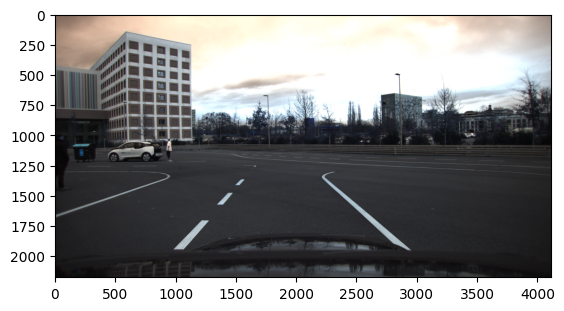

In [18]:
# original_image = mpimg.imread('data/image.png')
original_image = cv2.imread('data/image.png')
plt.imshow(original_image)
plt.show()

# resize the image by 50%
original_image = cv2.resize(original_image, (0,0), fx=0.2, fy=0.2)

# gaussian blur parameters
kernel_size=1

# canny parameters
canny_low=10
canny_high=180

# parameters for region of interest
vertices = np.array([[100, original_image.shape[0]], 
                      [450, original_image.shape[0]*0.5], 
                      [700, original_image.shape[0]*0.5], 
                      [original_image.shape[1], original_image.shape[0]]], np.int32)

# parameters for hough lines
theta=np.pi/180
threshold=40
rho=1
min_line_len=1
max_line_gap=100

#TODO: Build your pipeline that will draw lane lines on the original_image




## Questions

1. Describe your pipeline. 
2. Identify potential shortcomings with your current pipeline
3. Suggest possible improvements to your pipeline
4. What is the problem with classical algorithmic approaches in general compared to ML approaches?